# Acoustic Anomaly Detection based on Images with Azure AutoML for Images
## 06. AutoML for Images

<img src='https://github.com/retkowsky/CustomVision_Datasets/blob/master/anomaly.png?raw=true' width = 600>

Serge Retkowsky | serge.retkowsky@microsoft.com | 25-Oct-2022 | V3

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/AutoML%20for%20Images.png?raw=true" width=700>

Setup AutoML for Images:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models

Documentation:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-specific-hyperparameters

Supported Algorithms:
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

## 1. Informations

In [1]:
#!pip install pydub

In [2]:
import numpy as np
import json
import os
import urllib
import pandas as pd
import sys

from zipfile import ZipFile

In [3]:
print("Python version =", sys.version)

Python version = 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [4]:
import datetime

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2022-10-25 13:12:28


In [5]:
# Your local platform
import platform, socket, re, uuid, json, psutil, logging

def get_system_info():
    """
    system info
    """
    try:
        info = {}
        info['Platform'] = platform.system()
        info['Platform-release'] = platform.release()
        info['Platform-version'] = platform.version()
        info['Architecture'] = platform.machine()
        info['Hostname'] = socket.gethostname()
        info['IP-address'] = socket.gethostbyname(socket.gethostname())
        info['MAC-address'] = ':'.join(
            re.findall('..', '%012x' % uuid.getnode()))
        info['Processor'] = platform.processor()
        info['RAM'] = str(round(psutil.virtual_memory().total /
                                (1024.0**3))) + " Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)


json.loads(get_system_info())

{'Platform': 'Linux',
 'Platform-release': '5.15.0-1017-azure',
 'Platform-version': '#20~20.04.1-Ubuntu SMP Fri Aug 5 12:16:53 UTC 2022',
 'Architecture': 'x86_64',
 'Hostname': 'standardd13v2',
 'IP-address': '127.0.0.1',
 'MAC-address': '73:11:3b:16:2e:5b',
 'Processor': 'x86_64',
 'RAM': '55 Go'}

In [6]:
import azureml.core

print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 1.44.0


## 2. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

> Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [7]:
subscription_id = os.environ.get("SUBSCRIPTION_ID",
                                 "tobereplaced")
resource_group = os.environ.get("RESOURCE_GROUP", "tobereplaced")
workspace_name = os.environ.get("WORKSPACE_NAME", "tobereplaced")

In [8]:
from azureml.core import Workspace
try:
    ws = Workspace(subscription_id=subscription_id,
                   resource_group=resource_group,
                   workspace_name=workspace_name)
    ws.write_config()
    print("OK")

except:
    print("Error: Workspace not found")

OK


In [9]:
from azureml.core import Workspace

ws = Workspace.from_config()

In [10]:
ws.name, ws.resource_group

('azuremlvision', 'azuremlvision-rg')

## 3. Azure ML GPU Compute target setup
**You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training.** <br><br>
**AutoML models for image tasks require GPU SKUs and support NC and ND families.** We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [11]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "AutoML-Sound-GPU"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(
        vm_size='Standard_NC6',  #GPU cluster
        idle_seconds_before_scaledown=1800,  #Time out
        min_nodes=0,
        max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True,
                                   min_node_count=None,
                                   timeout_in_minutes=20)

Creating a new compute target...
InProgress.
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [12]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [13]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Resizing',
 'allocationStateTransitionTime': '2022-10-25T13:13:15.817000+00:00',
 'errors': None,
 'creationTime': '2022-10-25T13:13:15.126985+00:00',
 'modifiedTime': '2022-10-25T13:13:21.972809+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [14]:
# Compute VM size
compute_target.vm_size

'STANDARD_NC6'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [15]:
from azureml.core import Experiment

experiment_name = 'AutoMLImages-SoundAnomaly'
experiment = Experiment(ws, name=experiment_name)

In [16]:
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-SoundAnomaly,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In [17]:
os.chdir("spectograms")

In [18]:
# We have some images for the tags in directories we want to detect
print(os.listdir('.'))

['KO', 'OK']


In [19]:
for root, _, files in os.walk('.'):
    print("Dir:", root, " = ", len(files), "images files.")

Dir: .  =  0 images files.
Dir: ./KO  =  61 images files.
Dir: ./OK  =  61 images files.


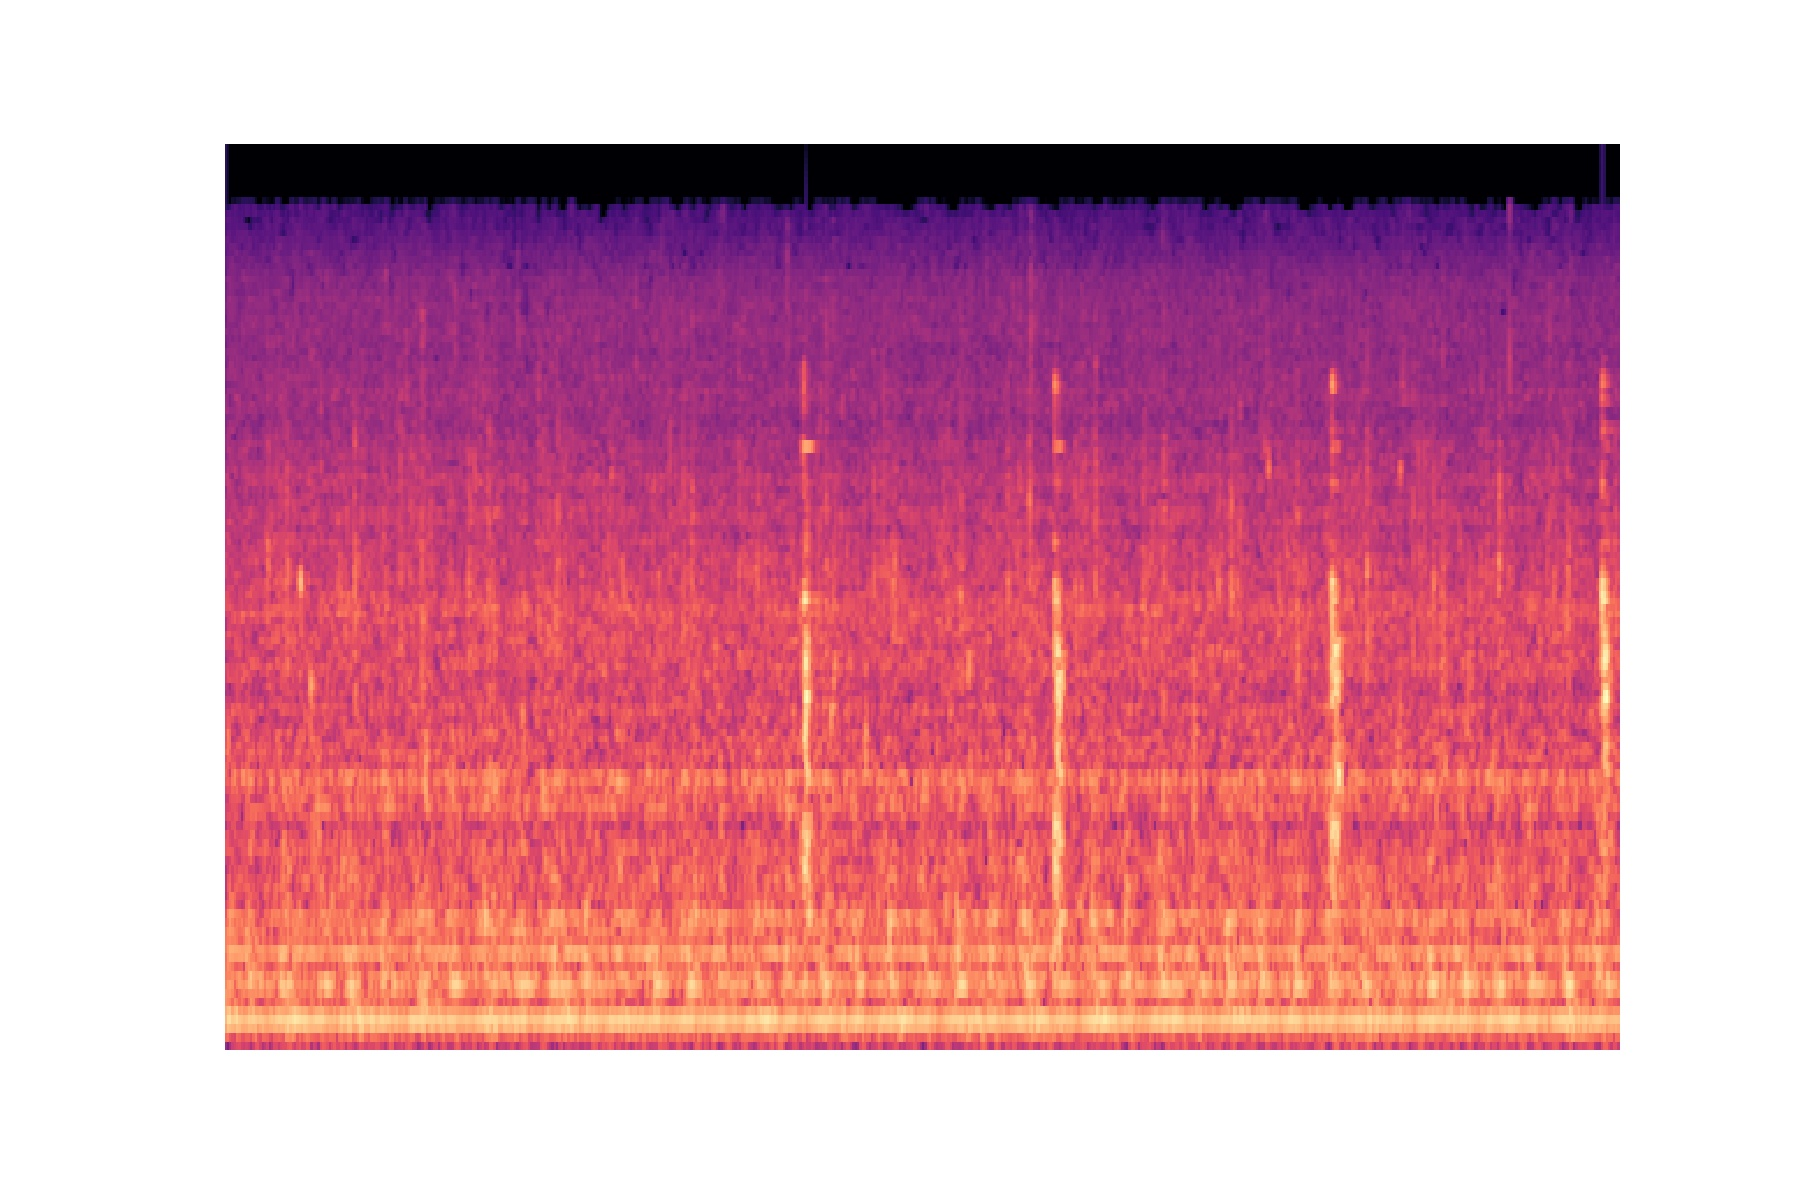

In [20]:
from IPython.display import Image

sample_image = 'KO/machine_KO_1.jpg'
Image(filename=sample_image)

### Convert the downloaded data to JSONL


In [21]:
os.chdir("..")

In [22]:
src = "spectograms/"

train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)),
        "label": "",
        "label_confidence": 1.0
    }

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing spectograms/KO
Parsing spectograms/OK


### Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [23]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir='./spectograms/', target_path='spectograms')

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 124 files
Uploading ./spectograms/train_annotations.jsonl
Uploaded ./spectograms/train_annotations.jsonl, 1 files out of an estimated total of 124
Uploading ./spectograms/validation_annotations.jsonl
Uploaded ./spectograms/validation_annotations.jsonl, 2 files out of an estimated total of 124
Uploading ./spectograms/KO/machine_KO_1.jpg
Uploaded ./spectograms/KO/machine_KO_1.jpg, 3 files out of an estimated total of 124
Uploading ./spectograms/KO/machine_KO_10.jpg
Uploaded ./spectograms/KO/machine_KO_10.jpg, 4 files out of an estimated total of 124
Uploading ./spectograms/KO/machine_KO_11.jpg
Uploaded ./spectograms/KO/machine_KO_11.jpg, 5 files out of an estimated total of 124
Uploading ./spectograms/KO/machine_KO_12.jpg
Uploaded ./spectograms/KO/machine_KO_12.jpg, 6 files out of an estimated total of 124
Uploading ./spectograms/KO/machine_KO_13.jpg
Uploaded ./spectograms/KO/machine_KO_13.jpg, 7 files out of an estimated total of 124
Uploading ./spectograms/KO/

Uploading ./spectograms/OK/machine_OK_42.jpg
Uploaded ./spectograms/OK/machine_OK_42.jpg, 107 files out of an estimated total of 124
Uploading ./spectograms/OK/machine_OK_43.jpg
Uploaded ./spectograms/OK/machine_OK_43.jpg, 108 files out of an estimated total of 124
Uploading ./spectograms/OK/machine_OK_48.jpg
Uploaded ./spectograms/OK/machine_OK_48.jpg, 109 files out of an estimated total of 124
Uploading ./spectograms/OK/machine_OK_51.jpg
Uploaded ./spectograms/OK/machine_OK_51.jpg, 110 files out of an estimated total of 124
Uploading ./spectograms/OK/machine_OK_52.jpg
Uploaded ./spectograms/OK/machine_OK_52.jpg, 111 files out of an estimated total of 124
Uploading ./spectograms/OK/machine_OK_53.jpg
Uploaded ./spectograms/OK/machine_OK_53.jpg, 112 files out of an estimated total of 124
Uploading ./spectograms/OK/machine_OK_54.jpg
Uploaded ./spectograms/OK/machine_OK_54.jpg, 113 files out of an estimated total of 124
Uploading ./spectograms/OK/machine_OK_55.jpg
Uploaded ./spectograms/O

$AZUREML_DATAREFERENCE_5250d451e7624a9d99ebd0eaaf50f0a0

In [24]:
ds

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-c3c87d4d-5b7e-436b-8a1a-5765a35e9878",
  "account_name": "azuremlvision8724517013",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [25]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'machinesoundTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION,
        path=ds.path('spectograms/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws,
                                                 name=training_dataset_name)

# create validation dataset
validation_dataset_name = "machinesoundValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION,
        path=ds.path('spectograms/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(
        workspace=ws, name=validation_dataset_name)

print()
print("Training dataset name:" + training_dataset.name)
print("Validation dataset name:" + validation_dataset.name)

Found the training dataset machinesoundTrainingDataset
Found the validation dataset machinesoundValidationDataset

Training dataset name:machinesoundTrainingDataset
Validation dataset name:machinesoundValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details.

This is what the training dataset looks like

In [26]:
images=training_dataset.to_pandas_dataframe()

In [27]:
images.head()

,image_url,label,label_confidence
0,StreamInfo(AmlDatastore://workspaceblobstore/s...,KO,1.0
1,StreamInfo(AmlDatastore://workspaceblobstore/s...,KO,1.0
2,StreamInfo(AmlDatastore://workspaceblobstore/s...,KO,1.0
3,StreamInfo(AmlDatastore://workspaceblobstore/s...,KO,1.0
4,StreamInfo(AmlDatastore://workspaceblobstore/s...,KO,1.0


In [28]:
images.shape

(97, 3)

In [29]:
images['label'].value_counts()

OK    49
KO    48
Name: label, dtype: int64

In [30]:
# Percentage values
images['label'].value_counts(normalize=True)

OK    0.505155
KO    0.494845
Name: label, dtype: float64

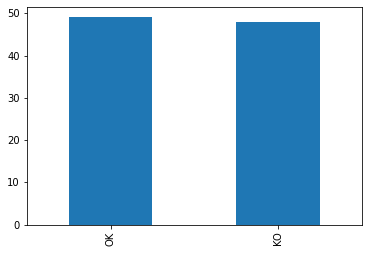

In [31]:
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt

images['label'].value_counts(sort=True).plot.bar()

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLImageConfig' - please refer to the [documentation](https://github.com/swatig007/automlForImages#readme) for the details on the parameters that can be used and their values. 

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones.<br><br> 

### Using default hyperparameter values for the specified algorithm

Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.


Supported Algorithms
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

In [32]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice
from azureml.automl.core.shared.constants import ImageTask

In [33]:
# AutoML Configuration
image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_CLASSIFICATION,  # AutoML Vision task
    compute_target=compute_target,  # Compute target
    training_data=training_dataset,  # Training dataset
    validation_data=validation_dataset,  # Validation dataset
    iterations=1,
    hyperparameter_sampling=GridParameterSampling(
        {'model_name': choice('vitb16r224')}))  # CV Model

## 7. Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, **you can submit an AutoML run** using the config in order to train a vision model using your training dataset.

In [34]:
automl_image_run = experiment.submit(image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLImages-SoundAnomaly,AutoML_3b829976-dce1-4b72-b6f6-2ce68b7b5aaf,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [35]:
automl_image_run.wait_for_completion(
    wait_post_processing=True)  # Wait until automl run is finished

{'runId': 'AutoML_3b829976-dce1-4b72-b6f6-2ce68b7b5aaf',
 'target': 'AutoML-Sound-GPU',
 'status': 'Completed',
 'startTimeUtc': '2022-10-25T13:15:23.509612Z',
 'endTimeUtc': '2022-10-25T13:29:33.044328Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'AutoML-Sound-GPU',
  'AMLSettingsJsonString': '{"path":null,"name":"AutoMLImages-SoundAnomaly","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"AutoML-Sound-GPU","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":true,"iterations":1,"primary_met

In [36]:
automl_image_run.id

'AutoML_3b829976-dce1-4b72-b6f6-2ce68b7b5aaf'

In [37]:
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-SoundAnomaly,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [38]:
from azureml.widgets import RunDetails

RunDetails(automl_image_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [39]:
# List of all the AutoML for Images metrics values

automlvisionmetrics = automl_image_run.get_metrics()
automlvisionmetrics

{'classification_report': {'class_name': ['KO',
   'OK',
   'micro avg',
   'macro avg',
   'weighted avg'],
  'precision': [0.90909, 0.78571, 0.84, 0.8474, 0.84987],
  'recall': [0.76923, 0.91667, 0.84, 0.84295, 0.84],
  'f1-score': [0.83333, 0.84615, 0.84, 0.83974, 0.83949],
  'support': [13.0, 12.0, 25.0, 25.0, 25.0],
  'auc': [0.88462, 0.88462, 0.9168, 0.88462, 0.88462],
  'average_precision': [0.92179, 0.85911, 0.9232, 0.89045, 0.89171]},
 'AUC_macro': [0.69872,
  0.83974,
  0.86538,
  0.85256,
  0.86538,
  0.88462,
  0.89103,
  0.88462,
  0.89103,
  0.88462,
  0.89103,
  0.88462,
  0.88462],
 'accuracy': [0.52,
  0.72,
  0.48,
  0.8,
  0.76,
  0.8,
  0.84,
  0.84,
  0.8,
  0.72,
  0.84,
  0.84,
  0.84],
 'f1_score_micro': [0.52,
  0.72,
  0.48,
  0.8,
  0.76,
  0.8,
  0.84,
  0.84,
  0.8,
  0.72,
  0.84,
  0.84,
  0.84],
 'AUC_micro': [0.6192,
  0.784,
  0.6624,
  0.7968,
  0.8784,
  0.8896,
  0.8144,
  0.8784,
  0.9088,
  0.896,
  0.9168,
  0.9168,
  0.9168],
 'precision_score_b

In [40]:
MYDIR = 'model'

if os.path.isdir(MYDIR) == True:
    print("Directory", MYDIR, "exists. So let's use it.")
    
if os.path.isdir(MYDIR) == False:
    print("Directory not exists. Creating directory... ", MYDIR)
    os.mkdir(MYDIR)
    print("Done.")

Directory not exists. Creating directory...  model
Done.


In [41]:
best_child_run = automl_image_run.get_best_child()
best_child_run.download_file("confusion_matrix",
                             output_file_path="model/confusion_matrix_1.json")

with open('model/confusion_matrix_1.json') as f:
    cm = json.load(f)

print("Confusion Matrix:")
print(cm['data']['class_labels'])
print(cm['data']['matrix'][0])
print(cm['data']['matrix'][1])

total_cm = cm['data']['matrix'][0][0] + cm['data']['matrix'][0][1] + cm[
    'data']['matrix'][1][0] + cm['data']['matrix'][1][1]
acc = (cm['data']['matrix'][0][0] + cm['data']['matrix'][1][1]) / total_cm
err = 1 - acc
print("\nAccuracy =", round(acc, 5))
print("Error =", round(err, 5))

Confusion Matrix:
['KO', 'OK']
[10, 3]
[1, 11]

Accuracy = 0.84
Error = 0.16


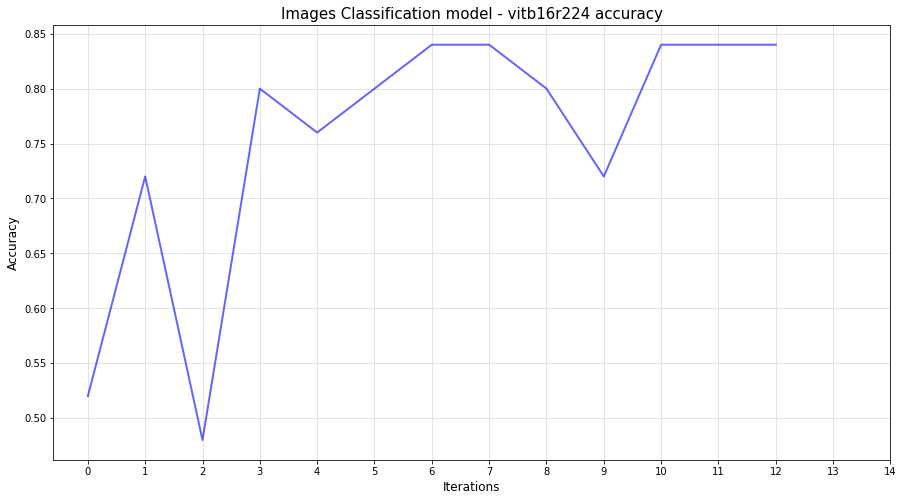

In [42]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(automlvisionmetrics['accuracy'], 'b-', lw=2, alpha=.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Images Classification model - vitb16r224 accuracy', fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('model/automl1_accuracy.png')
automl_image_run.log_image(
    name='model/automl1_vitb16r224.png',
    plot=plt)  # Logging the graph into the Azure ML experiment

plt.show()

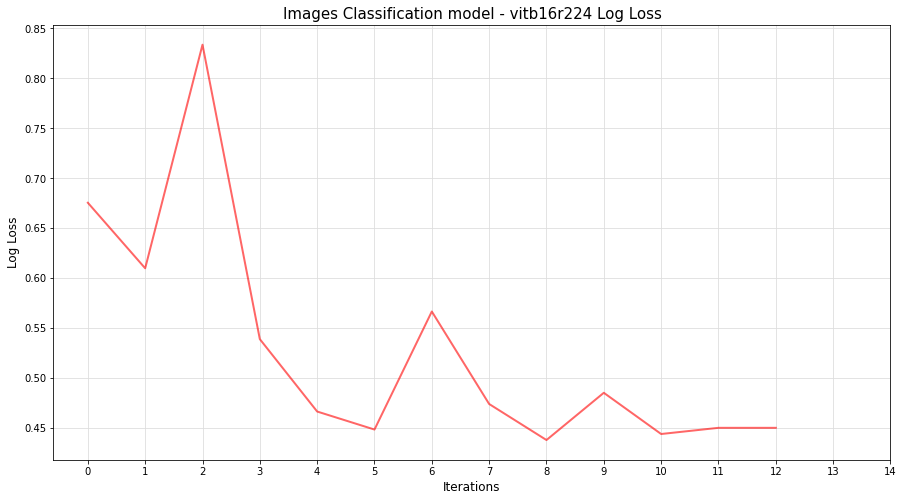

In [43]:
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(automlvisionmetrics['log_loss'], 'r-', lw=2, alpha=.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('Images Classification model - vitb16r224 Log Loss', fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('model/automl1_logloss.png')

plt.show()

In [44]:
# You can view the jpg file in the experiment
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-SoundAnomaly,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## Let's improve using additionals models & hyperparameter tuning

### Hyperparameter sweeping for your AutoML models for computer vision tasks

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space, to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, **choosing from a range of values for learning_rate, optimizer, lr_scheduler, etc, to generate a model with the optimal 'accuracy'.** If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use **Random Sampling to pick samples from this parameter space and try a total of 10 iterations** with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We also leverage the **Bandit early termination policy** that terminates poor performing configs (those that are not within 20% slack of the best perfroming config), thus significantly saving compute resources.

Supported Algorithms
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

In [45]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "learning_rate":
    uniform(0.001, 0.01),
    "model":
    choice(
        {
            "model_name": choice("vitb16r224", "vits16r224"),
            "number_of_epochs": choice(15, 30),
        },
        {
            "model_name": choice("seresnext", "resnest50"),
            "layers_to_freeze": choice(0, 1, 2, 3),
        },
    ),
}

tuning_settings = {
    "iterations":
    10,
    "max_concurrent_iterations":
    4,
    "hyperparameter_sampling":
    RandomParameterSampling(parameter_space),
    "early_termination_policy":
    BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6),
}

automl_image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_CLASSIFICATION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

In [46]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLImages-SoundAnomaly,AutoML_0384833b-9bb6-4cc1-9d51-30718a8ea54b,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [47]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_0384833b-9bb6-4cc1-9d51-30718a8ea54b',
 'target': 'AutoML-Sound-GPU',
 'status': 'Completed',
 'startTimeUtc': '2022-10-25T13:34:21.66716Z',
 'endTimeUtc': '2022-10-25T13:52:29.879725Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'AutoML-Sound-GPU',
  'AMLSettingsJsonString': '{"path":null,"name":"AutoMLImages-SoundAnomaly","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"AutoML-Sound-GPU","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":true,"iterations":1,"primary_metr

> When doing a hyperparameter sweep, **it can be useful to visualize the different configurations that were tried using the HyperDrive UI**. <br><br>You can navigate to this UI by going to the **'Child runs' tab in the UI of the main automl_image_run** from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this one.

In [48]:
experiment

Name,Workspace,Report Page,Docs Page
AutoMLImages-SoundAnomaly,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


### You will see all the AutoML runs from the Child runs section. 
The **model column** will display detailled information about each model.<br>
Example:

<img src="https://github.com/retkowsky/images/blob/master/automlvision.jpg?raw=true">

In [49]:
from azureml.widgets import RunDetails

RunDetails(automl_image_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [50]:
best_child_run = automl_image_run.get_best_child()
best_child_run.download_file("confusion_matrix",
                             output_file_path="model/confusion_matrix_2.json")

with open('model/confusion_matrix_2.json') as f:
    cm = json.load(f)

print("Confusion Matrix:")
print(cm['data']['class_labels'])
print(cm['data']['matrix'][0])
print(cm['data']['matrix'][1])

total_cm = cm['data']['matrix'][0][0] + cm['data']['matrix'][0][1] + cm[
    'data']['matrix'][1][0] + cm['data']['matrix'][1][1]
acc = (cm['data']['matrix'][0][0] + cm['data']['matrix'][1][1]) / total_cm
err = 1 - acc

print("\nAccuracy =", round(acc, 5))
print("Error =", round(err, 5))

Confusion Matrix:
['KO', 'OK']
[10, 3]
[0, 12]

Accuracy = 0.88
Error = 0.12


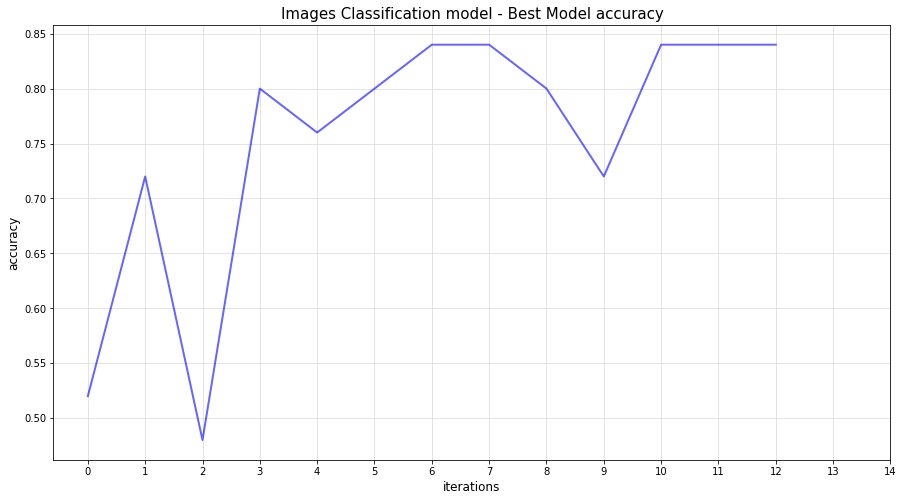

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(automlvisionmetrics['accuracy'], 'b-', lw=2, alpha=.6)
plt.xlabel('iterations', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.title('Images Classification model - Best Model accuracy', fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('model/automl2_accuracy.png')  # Saving image in a jpg file
automl_image_run.log_image(
    name='model/automl2_accuracy.png',
    plot=plt)  # Logging the graph into the Azure ML experiment

plt.show()

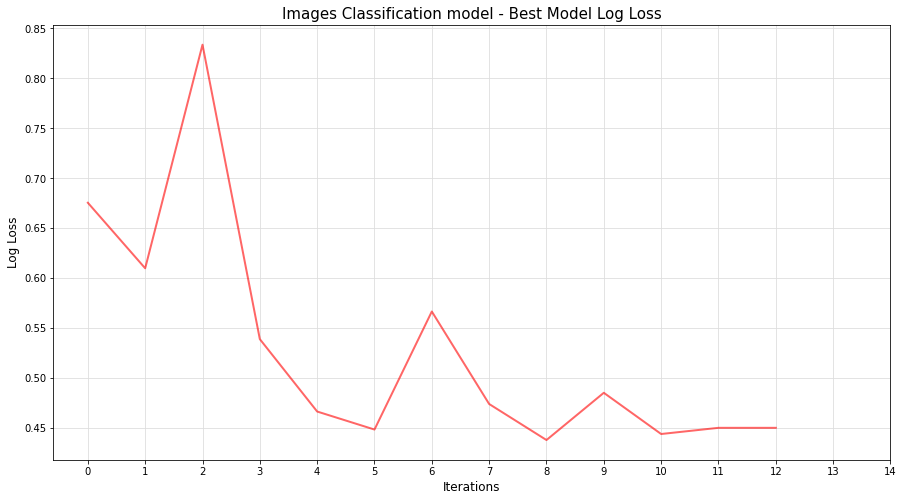

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(automlvisionmetrics['log_loss'], 'r-', lw=2, alpha=.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('Images Classification model - Best Model Log Loss', fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 15, 1))
plt.savefig('model/automl2_logloss.png')

plt.show()

> You can find all the artefacts from the output+logs section of Azure ML

## 8. Register the optimal CV model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [53]:
from azureml.core import Run

hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoMLImages-SoundAnomaly,AutoML_0384833b-9bb6-4cc1-9d51-30718a8ea54b_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [54]:
# Defining tags for the custom vision model
cvmodel_tags = {
    "Data": "Images",
    "Context": "Sound Anomaly",
    "Task": "Best AutoML Images",
    "Framework": "AzureML AutoML for Images",
    "AutoML Metric": "Accuracy"
}

In [55]:
# Register the best model from the AutoML Vision run in ONNX file format
best_child_run = automl_image_run.get_best_child()

model = best_child_run.register_model(model_name='SoundAnomalyONNX',
                                      model_path='train_artifacts/model.onnx',
                                      description='Sound Anomaly',
                                      tags=cvmodel_tags)

In [56]:
# We can download the CV model ONNX
model.download(target_dir='model', exist_ok=True, exists_ok=None)

'model/model.onnx'

In [57]:
# Checking the downloaded ONNX model file
!ls model/model.onnx -lh

-rwxrwxrwx 1 root root 328M Oct 25 13:55 model/model.onnx


In [58]:
# Defining tags for the custom vision model
cvmodel_tags = {
    "Data": "Images",
    "Context": "Sound Anomaly",
    "Task": "Best AutoML Images",
    "Framework": "AzureML AutoML for Images",
    "AutoML Metric": "Accuracy"
}

In [59]:
# Register the best model from the AutoML Vision run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name=model_name,
                                      model_path='outputs/model.pt',
                                      description='Sound Anomaly',
                                      tags=cvmodel_tags)

In [60]:
# We can download the CV model
model.download(target_dir='model', exist_ok=True, exists_ok=None)

'model/model.pt'

In [61]:
# Checking the downloaded .pt model file
!ls model/model.pt -lh

-rwxrwxrwx 1 root root 655M Oct 25 13:56 model/model.pt


### Model informations from the Azure ML model repository

In [62]:
model

Model(workspace=Workspace.create(name='azuremlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='azuremlvision-rg'), name=AutoML0384833b93, id=AutoML0384833b93:1, version=1, tags={'Data': 'Images', 'Context': 'Sound Anomaly', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'Accuracy'}, properties={})

In [63]:
model.id

'AutoML0384833b93:1'

In [64]:
model.name

'AutoML0384833b93'

In [65]:
model.version

1

In [66]:
model.tags

{'Data': 'Images',
 'Context': 'Sound Anomaly',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'Accuracy'}

In [67]:
model.created_time

datetime.datetime(2022, 10, 25, 13, 55, 43, 728262, tzinfo=<isodate.tzinfo.Utc object at 0x7f93b04e2b80>)

## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. **You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)).**<br><br> ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage. <br><br>
**In this tutorial, we will deploy the model as a web service in AKS.**
You will need to first create an AKS compute cluster, or use an existing AKS cluster. <br>
You can use either GPU or CPU VM SKUs for your deployment cluster

In [68]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-cluster"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing compute target.')

except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6",
                                                        location="westeurope")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws,
                                      name=aks_name,
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target.
CPU times: user 22.1 ms, sys: 5.23 ms, total: 27.3 ms
Wall time: 135 ms


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [69]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

endpoint_name = 'automlcv-machine-sound-anomaly'  # Name of the deployed model

aks_tags = {
    "Data": "Images",
    "Topic": "Sound Anomaly",
    "Task": "Image Classification",
    "Framework": "AutoML Images best model",
    "AKS": "True"
}

aks_description = "Computer vision model to detect Sound Anomaly"

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py',
                             output_file_path='model/score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='model/score.py',
                                   environment=environment)

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

In [70]:
# Checking the file we downloaded
!ls model/score.py -lh

-rwxrwxrwx 1 root root 2.1K Oct 25 13:56 model/score.py


In [71]:
# Viewing the score.py file
with open('model/score.py', 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse
from azureml.core.model import Model

from azureml.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.automl.dnn.vision.common.logging_utils import get_logger

from azureml.automl.dnn.vision.classification.inference.score import _score_with_model

TASK_TYPE = 'image-classification'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model

    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = os.path.join(os.getenv('AZ

### Let's deploy the CV model into AKS

In [72]:
%%time

aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=endpoint_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)

print("\nDone. Model is deployed. Ready to use!")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-10-25 13:56:45+00:00 Creating Container Registry if not exists.
2022-10-25 13:56:45+00:00 Registering the environment.
2022-10-25 13:56:46+00:00 Use the existing image.
2022-10-25 13:56:47+00:00 Creating resources in AKS.
2022-10-25 13:56:48+00:00 Submitting deployment to compute.
2022-10-25 13:56:48+00:00 Checking the status of deployment automlcv-machine-sound-anomaly..
2022-10-25 13:57:19+00:00 Checking the status of inference endpoint automlcv-machine-sound-anomaly.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed. Ready to use!

AKS service status= Healthy
CPU times: user 1.1 s, sys: 148 ms, total: 1.25 s
Wall time: 45.1 s


> Usually it takes 2 or 3 minutes to deploy. You can see the endpoint in Azure ML Studio

In [74]:
#print("CV model endpoint:", aks_service.scoring_uri)
print("CV model endpoint properties:", aks_service.properties)
print("CV model endpoint tags:", aks_service.tags)

CV model endpoint properties: {'hasInferenceSchema': 'True', 'hasHttps': 'False', 'authEnabled': 'True'}
CV model endpoint tags: {'Data': 'Images', 'Topic': 'Sound Anomaly', 'Task': 'Image Classification', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


In [75]:
# You can have access to the logs
#print(aks_service.get_logs())

In [77]:
#print("Our CV model endpoint:", aks_service.scoring_uri)
print("\nStatus=", aks_service.state)


Status= Healthy


## 11. Clean up ressources

In [78]:
#aks_service.delete()

In [79]:
compute_target.delete()

> You can run the next notebook

Note: All these Python notebooks were made for demo purposes. They were not designed for production usage. Some feature can be currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews. https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/